In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analyats focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a very basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used in LTSM models.  <br>
I obtained historical stock data by using the Pandas library DataReader.  The library provides price and volumne information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
I will use Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing a COVID-19 vaccine: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

My technical analysis will focus on answering the following questions and algorithmic models regarding the trends  and performance of the above stocks:
### Question 1: 
Can technical indicators alone provide an investor or trader with information to make a decision of when to buy and sell stocks?<br>
**Answer** Techincal Indicators as used in this notebook will provide historical price analysis  regarding volatility and trends of the stock.
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  However, technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, prices changes and MACD to analyze price trends.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns.<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2** An Exponential Moving Average Plot.<br>
**Model 3** Exponential Moving Average Crossover Stratergy

### Question 2:
How well can historical data  and algorithms predict future stocks prices?  I will contrast the performance of predictions of LSTM models and LTSM models with technical indicators.  Is there a difference in the RMSE metrics when comparing models?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms LTSM or ARIMA performs better at predicting stocks prices?  
**Model 1** is an SARIMA model.<br>


## Get the Historical Stock Data

### Multiple Stocks Data

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            plt.title("HistoricL Stock Adjusted Price Data")
            plt.xlabel('Dates')
            plt.ylabel('Stock Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


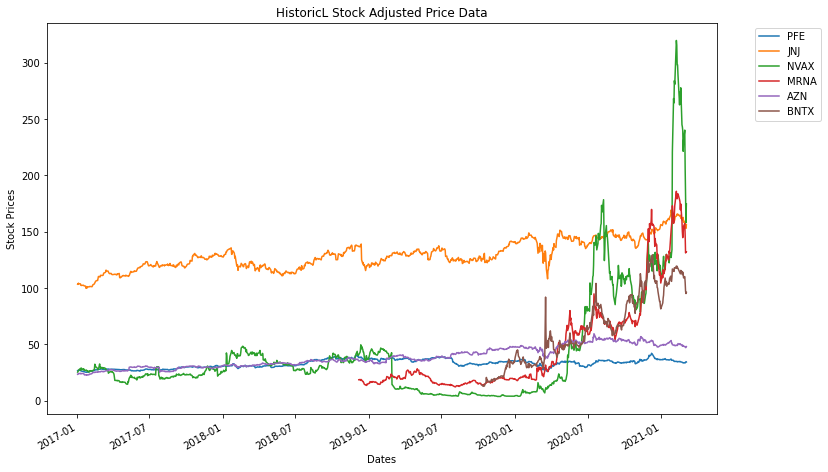

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data;

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')
multi_stocks

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-03-01,33.689999,159.320007,240.289993,157.399994,48.090000,110.209999
2021-03-02,33.509998,159.020004,205.990005,146.809998,47.730000,104.980003
2021-03-03,34.389999,156.220001,183.610001,131.220001,47.160000,97.250000


##### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
    return df    

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-03-01,33.689999,159.320007,240.289993,157.399994,48.090000,110.209999
2021-03-02,33.509998,159.020004,205.990005,146.809998,47.730000,104.980003
2021-03-03,34.389999,156.220001,183.610001,131.220001,47.160000,97.250000


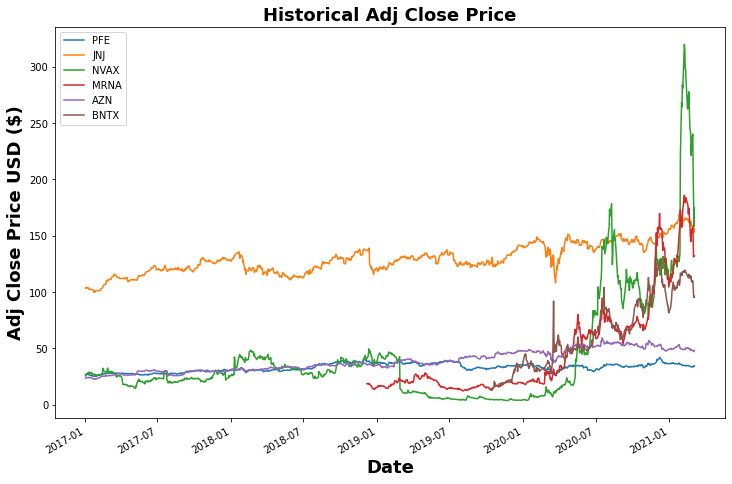

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1050.000000,1050.000000,1050.000000,564.000000,1050.000000,353.000000
mean,32.861207,129.489451,41.817933,47.934105,38.513809,63.350538
std,3.691471,13.270900,48.833852,42.959896,9.136453,31.393765
min,25.159119,99.793396,3.690000,12.260000,22.596422,12.750000
25%,30.032526,120.240448,12.510000,17.760001,30.799058,35.000000
50%,33.034033,128.082588,27.000000,23.565001,36.237322,59.299999
75%,36.102255,138.385662,42.150001,68.457502,46.994754,88.279999
max,42.101986,169.423508,319.929993,185.979996,59.466022,129.539993


### Single Stock Data

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single

    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

In [10]:
start='01-01-2019'
end='today'
#pfe_stock = single_stock_data('PFE', start='01-01-2017',end='today',plot=True,stock_value='Adj Close')

In [11]:
#pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

##### Single Stock Plot

In [12]:
def single_plot(df,stock_value=None):
    #plt.figure(figsize=(12,8))
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Data',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
    #return df

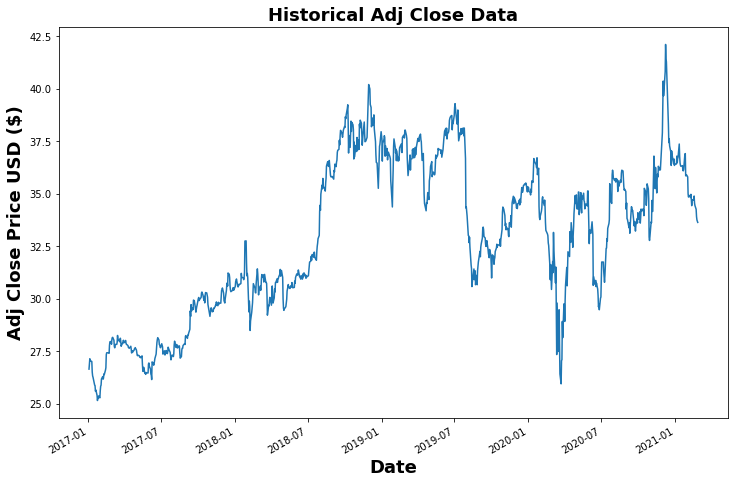

In [13]:
single_plot(pfe_stock_data, stock_value='Adj Close')

In [14]:
pfe_stock_data['Adj Close'].describe()

count    1044.000000
mean       32.854801
std         3.700994
min        25.159119
25%        30.004087
50%        33.005838
75%        36.110478
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The practice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is part of algorithmic trading. What are technical indicators and how are used by Technical Analyst in stock trading?  Technical indicators are approaches or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements. https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss the below popular technical indicators which are used in the markets to study price movements:

1. Moving Averages (MA)
    > Simple Moving Average<br>
    > Exponential Moving Average<br>
2. Rate of Change (ROC)
3. Relative Strength Index (RSI)

### Moving Averages
The moving average is also known as the rolling mean or running average.  Moving averages smooth out the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving Average smooths out the variations in the dataset by calculating the moving average.  Three common types of moving averages are Simple Moving Average (SMA), Weighted Moving Average (WMA) and Exponential Moving Average (EMA).  Commonly time periods used for moving averages are 5, 10, 20, 50, 200 days.  A 10 time period SMA would mean 10 trading days.<br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the Python rolling method to calculate moving averages.<br>  
<br>
The below plot shows a lot of fluctuations and noise in the stock price.  The plot shows the average stock price with the 10 and 20-day moving averages.  The 10-day follows the Adj Close price closely buy smooths out the positve and negative spikes in prices.<br>
Aound 2/18, there was a spike in price from \\$30.75 to almost \\$33.00 and then dropped quickly to almost $28.50.  What is the SMA showing us?  SMA gives a more realistic picture of what happened with stock the price. It may have increased and dropped precipitously.  We may not know what precipitated such activity, but what were the 10 and 20 day averages around this time period for a more accurate picture of what the stock price was for that period?<br>  We can see that with the subset of 50 day rolling average data the stock's average price was \\$30.26.
Around 8/2019, the price was pretty volatile.  The SMA smooths out the noise and gives a more accurate picture.<br>

In [15]:
rolling_method = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#how big should the subset of data be that we're calculating the moving average on?

In [16]:
def sma(data, col1=None,col2=None,col=None,roll1=None,roll2=None):
    data[col1] = data[col].rolling(10).mean()
    data[col2] = data[col].rolling(50).mean()

    return data#['2017-01-01':'2021-2-19']

##### Qestion 1 / Model 1

In [17]:
sma_rolling = sma(rolling_method, col='Close',col1='MA_10',col2='MA_50',roll1=10,roll2=50)
sma_rolling

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50
Date,,,,,,,,
2017-01-03,31.309298,30.920303,31.024668,31.309298,23391844.0,26.653324,NaN,NaN
2017-01-04,31.641365,31.337761,31.432638,31.584440,22753963.0,26.887548,NaN,NaN
2017-01-05,31.963947,31.423149,31.660341,31.888046,21083584.0,27.146002,NaN,NaN
2017-01-06,31.973434,31.631880,31.935484,31.764706,18418228.0,27.041008,NaN,NaN
2017-01-09,31.944971,31.669828,31.717268,31.755219,21559886.0,27.032928,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-19,34.680000,34.400002,34.660000,34.439999,28089400.0,34.439999,34.7180,36.8370
2021-02-22,34.369999,34.040001,34.330002,34.259998,34247500.0,34.259998,34.6520,36.6710
2021-02-23,34.189999,33.680000,34.000000,33.910000,37603300.0,33.910000,34.5610,36.5122


In [18]:
sma_rolling['Close'].describe(), sma_rolling['MA_50'].describe()

(count    1044.000000
 mean       35.591444
 std         3.316146
 min        27.030361
 25%        33.384725
 50%        34.824612
 75%        37.893738
 max        43.861481
 Name: Close, dtype: float64,
 count    995.000000
 mean      35.709622
 std        2.992630
 min       31.284440
 25%       33.892979
 50%       34.778937
 75%       37.714399
 max       41.757495
 Name: MA_50, dtype: float64)

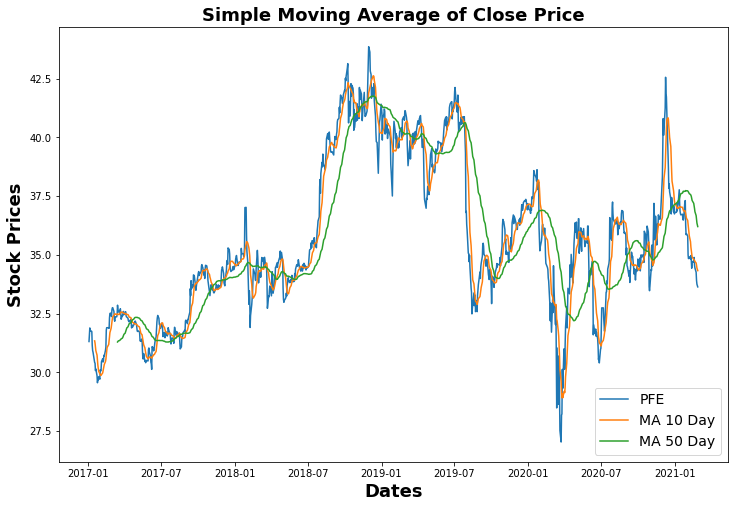

In [82]:
plt.figure(figsize=(12,8))
plt.plot(sma_rolling['Close'], label='PFE')
plt.plot(sma_rolling['MA_10'], label='MA 10 Day')
plt.plot(sma_rolling['MA_50'],label='MA 50 Day')
label_font = {'weight':'bold','size':18}
plt.title('Simple Moving Average of Close Price',fontdict=label_font)
plt.xlabel('Dates',fontdict=label_font)
plt.ylabel('Stock Prices',fontdict=label_font)
plt.legend(loc='lower right', fontsize=14);

In [20]:
rolling_50_sub = rolling_method['MA_50']['2017-12-01':'2018-3-01']
rolling_50_sub.describe()

count    61.000000
mean     34.270483
std       0.260858
min      33.929412
25%      34.036243
50%      34.222391
75%      34.522391
max      34.675522
Name: MA_50, dtype: float64

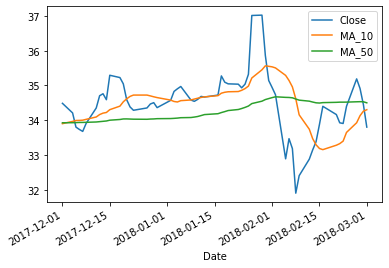

In [81]:
sma_rolling[['Close','MA_10','MA_50']]['2017-12-01':'2018-3-01'].plot()

##### Moving Average Convergence/Divergence

In [22]:
sma_rolling_1 = sma_rolling.copy()

In [23]:
sma_rolling_1['Signal'] = 0.0
sma_rolling_1['Signal'] = np.where(sma_rolling_1['MA_10'] > sma_rolling_1['MA_50'], 1.0, 0.0)
sma_rolling_1['Position'] = sma_rolling_1['Signal'].diff()


In [24]:
sma_rolling_1 = sma_rolling_1.dropna()

In [25]:
sma_rolling_1.head()

,High,Low,Open,Close,Volume,Adj Close,MA_10,MA_50,Signal,Position
Date,,,,,,,,,,
2017-03-15,32.922199,32.428844,32.466793,32.855785,24279839.0,28.254789,32.485769,31.289754,1.0,1.0
2017-03-16,32.855785,32.495255,32.798862,32.666035,21816219.0,28.091606,32.478179,31.316888,1.0,0.0
2017-03-17,32.808350,32.514233,32.694496,32.561668,45736117.0,28.001856,32.459203,31.336433,1.0,0.0
2017-03-20,32.732449,32.561668,32.637569,32.618595,18435514.0,28.050808,32.462049,31.351044,1.0,0.0
2017-03-21,32.836811,32.428844,32.713470,32.495255,33083479.0,27.944742,32.486717,31.365655,1.0,0.0


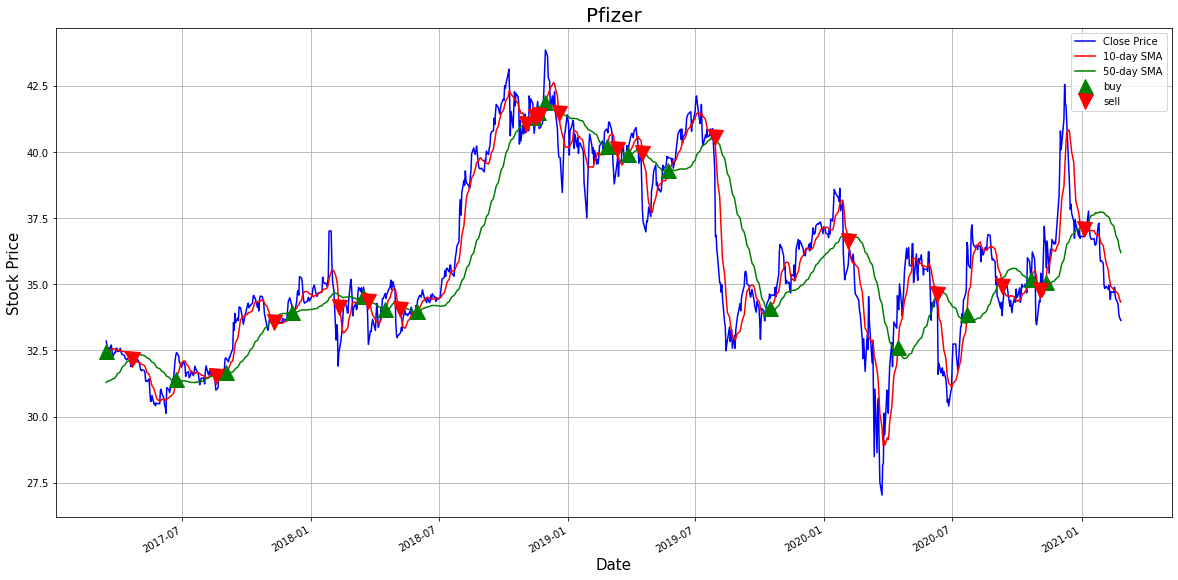

In [26]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
sma_rolling_1['Close'].plot(color = 'b', label= 'Close Price') 
sma_rolling_1['MA_10'].plot(color = 'r',label = '10-day SMA') 
sma_rolling_1['MA_50'].plot(color = 'g', label = '50-day SMA')
# plot ‘buy’ signals
plt.plot(sma_rolling_1[sma_rolling_1['Position'] == 1].index, 
         sma_rolling_1['MA_10'][sma_rolling_1['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(sma_rolling_1[sma_rolling_1['Position'] == -1].index, 
         sma_rolling_1['MA_10'][sma_rolling_1['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [84]:
sma_rolling_2 = sma_rolling_1['2018-01-01':'2018-07-01']

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



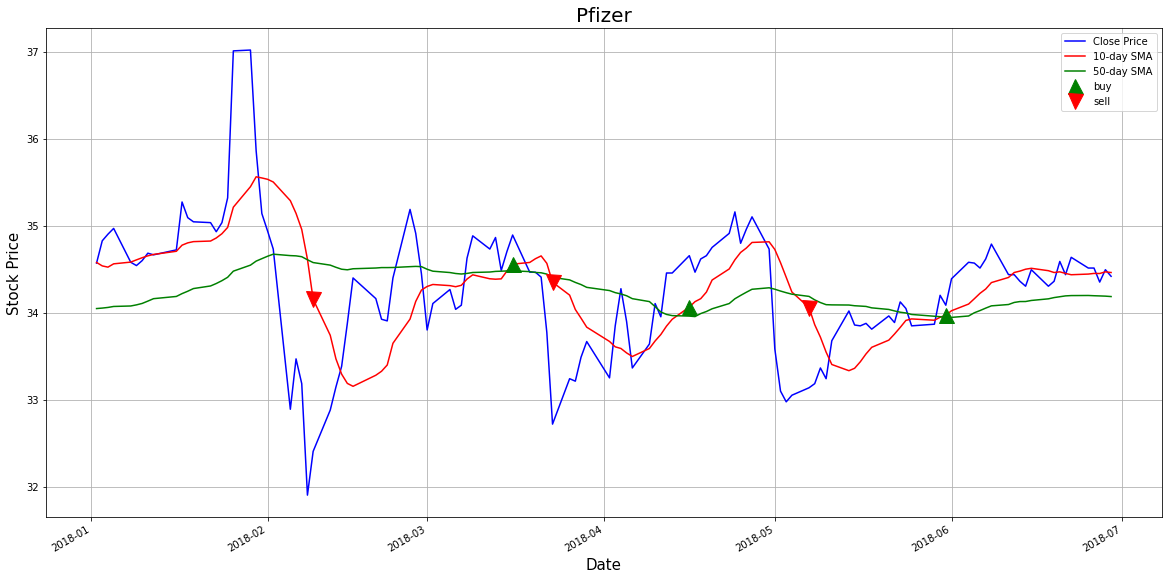

In [85]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
sma_rolling_2['Close'].plot(color = 'b', label= 'Close Price') 
sma_rolling_2['MA_10'].plot(color = 'r',label = '10-day SMA') 
sma_rolling_2['MA_50'].plot(color = 'g', label = '50-day SMA')
# plot ‘buy’ signals
plt.plot(sma_rolling_2[sma_rolling_1['Position'] == 1].index, 
         sma_rolling_2['MA_10'][sma_rolling_1['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(sma_rolling_2[sma_rolling_2['Position'] == -1].index, 
         sma_rolling_2['MA_10'][sma_rolling_2['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. This technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical price average.  https://www.investopedia.com/terms/e/ema.asp
 <br>
When red line crosses above the green line you see a increase in the price and every time the red drops below the EMA26 you see the price decrease.

In [27]:
pfe_df = pfe_stock_data.copy()

In [28]:
# #single_stock
# #good time of when to buy stockand when to sell it
# #three moving avrages
# #short/fast exponential moving ma
def create_ema_function(data, col='Close',span1=None,span2=None,span3=None):
    data['shortEMA'] = data[col].ewm(span=span1, adjust=False).mean() #5 time periods
    #calculate middle/medium exponential moving ma
    data['middleEMA'] = data[col].ewm(span=span2, adjust=False).mean() #5 time periods
    #calculate long/slow exponential moving ma
    data['longEMA'] = data[col].ewm(span=span3, adjust=False).mean() #5 time periods
    
    #visulaize closing price and exponential moving average
    plt.figure(figsize=(12,6))
    plt.plot(data[col],label='Adj Close Price', color='blue')
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red')
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange')
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green')
    plt.title('Exponential Moviing Average Plot')
    plt.xlabel('Dates')
    plt.ylabel('Closing Price')
    plt.legend()
    
    return data #, shortEMA, middleEMA,longEMA

,Close,Volume,Adj Close,shortEMA,middleEMA,longEMA
Date,,,,,,
2017-01-03,31.309298,23391844.0,26.653324,31.309298,31.309298,31.309298
2017-01-04,31.584440,22753963.0,26.887548,31.401012,31.334311,31.317896
2017-01-05,31.888046,21083584.0,27.146002,31.563357,31.384650,31.335713
2017-01-06,31.764706,18418228.0,27.041008,31.630473,31.419201,31.349119
2017-01-09,31.755219,21559886.0,27.032928,31.672055,31.449748,31.361810


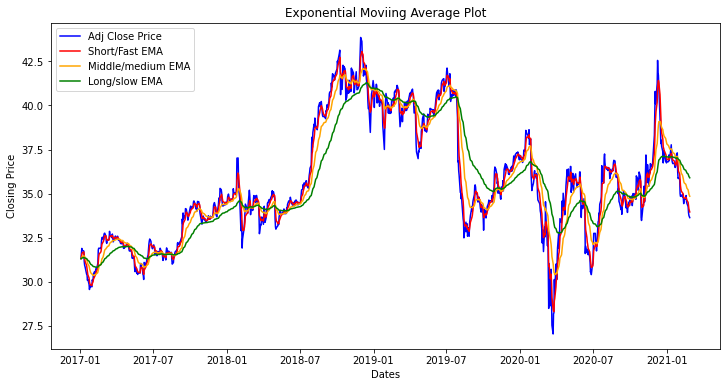

In [29]:
ewma1 = create_ema_function(data=pfe_df, span1=5, span2=21,span3=63)
ewma1.head()

#### Exponential Moving Average Crossover Stratergy
Stock market analysts and investors use Exponential Moving Average Crossover strategy, among other moving averages, to analyze price trends and predict upcoming change of trends.  A moving-average crossover occurs when plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period.  A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>

In [30]:
#function to buy and sell the stock
#buy sell signals
def buy_sell_function(data):
    buy_list = []
    sell_list=[]
    flag_long = False
    flag_short = False

    for i in range(0, len(data)):
        if data['middleEMA'][i] < data['longEMA'][i] and data['shortEMA'][i]< data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_short = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_short == True and data['shortEMA'][i] > data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_short = False
            
        elif data['middleEMA'][i] > data['longEMA'][i] and data['shortEMA'][i]> data['middleEMA'][i] and flag_long== False and flag_short== False:
                #this is when to buy stock
                buy_list.append(data['Close'][i])
                sell_list.append(np.nan)
                flag_long = True
        #sell if the short/fast moving average crosses above the middle moving average
        elif flag_long == True and data['shortEMA'][i] < data['middleEMA'][i]:
            sell_list.append(data['Close'][i])
            buy_list.append(np.nan)
            flag_long = False 
        else:
            #if conditions not met for any statement just append to buy, sell lists a nan value
            buy_list.append(np.nan)
            sell_list.append(np.nan)
            
           
    return buy_list, sell_list       
            

In [31]:
#add buy and sell signals to dataset
ewma1['Buy'] = buy_sell_function(pfe_df)[0] #return index 0
ewma1['Sell'] = buy_sell_function(pfe_df)[1] #return inddex 1

In [32]:
def ema_signals_function(data):
    plt.figure(figsize=(12,8))
    plt.plot(data['Close'],label='Close Price', color='blue',alpha=0.35)
    plt.plot(data['shortEMA'],label='Short/Fast EMA', color='red',alpha=0.35)
    plt.plot(data['middleEMA'],label='Middle/medium EMA', color='orange',alpha=0.35)
    plt.plot(data['longEMA'],label='Long/slow EMA', color='green',alpha=0.35)
    plt.scatter(data.index,data['Buy'], color='green', marker='^', alpha=1)
    #prices are going to go down
    plt.scatter(data.index,data['Sell'], color='red',marker='v',alpha=1)
    plt.title('Buy and Sell Graph')
    plt.legend() 

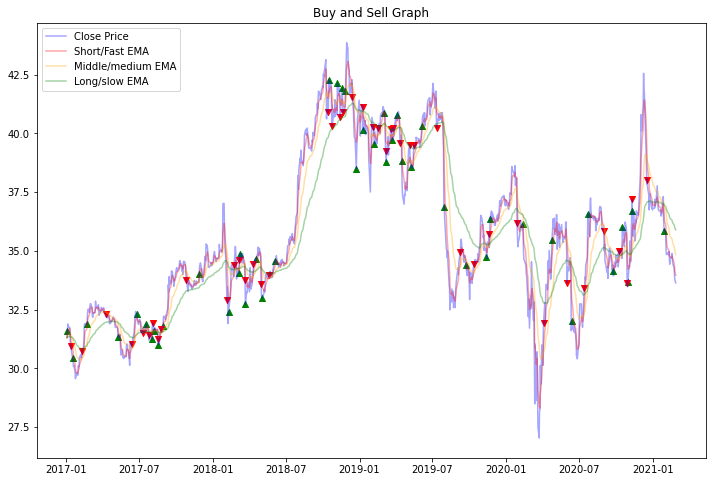

In [33]:
ema_signals_function(data=ewma1)

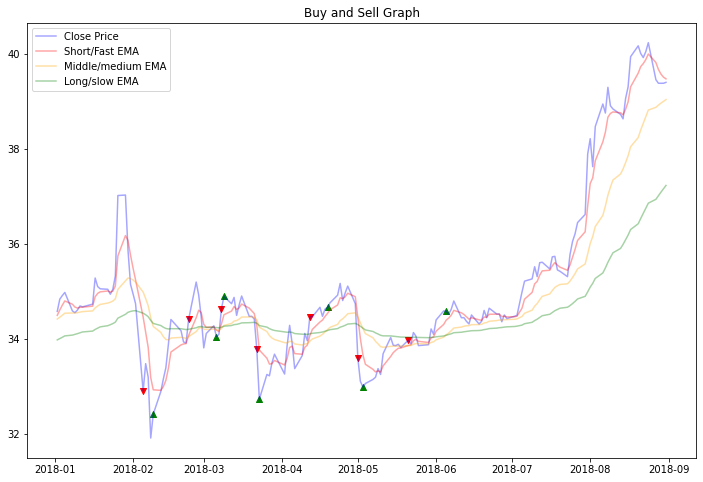

In [34]:
ema_signals_function(data=ewma1['2018-01-01':'2018-09-01'])

In [35]:
ewma1

,Close,Volume,Adj Close,shortEMA,middleEMA,longEMA,Buy,Sell
Date,,,,,,,,
2017-01-03,31.309298,23391844.0,26.653324,31.309298,31.309298,31.309298,NaN,NaN
2017-01-04,31.584440,22753963.0,26.887548,31.401012,31.334311,31.317896,31.58444,NaN
2017-01-05,31.888046,21083584.0,27.146002,31.563357,31.384650,31.335713,NaN,NaN
2017-01-06,31.764706,18418228.0,27.041008,31.630473,31.419201,31.349119,NaN,NaN
2017-01-09,31.755219,21559886.0,27.032928,31.672055,31.449748,31.361810,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-19,34.439999,28089400.0,34.439999,34.618384,35.303830,36.168911,NaN,NaN
2021-02-22,34.259998,34247500.0,34.259998,34.498922,35.208937,36.109257,NaN,NaN
2021-02-23,33.910000,37603300.0,33.910000,34.302614,35.090851,36.040531,NaN,NaN


In [36]:
ewmal_1 = ewma1.copy() 

In [37]:
# Create 20 days exponential moving average column
ewmal_1['20_EMA'] = ewmal_1['Close'].ewm(span = 20, adjust = False).mean()
# Create 50 days exponential moving average column
ewmal_1['50_EMA'] = ewmal_1['Close'].ewm(span = 50, adjust = False).mean()

In [38]:
# create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
  
ewmal_1['Signal'] = 0.0  
ewmal_1['Signal'] = np.where(ewmal_1['20_EMA'] > ewmal_1['50_EMA'], 1.0, 0.0)


In [39]:
# create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
ewmal_1['Position'] = ewmal_1['Signal'].diff()

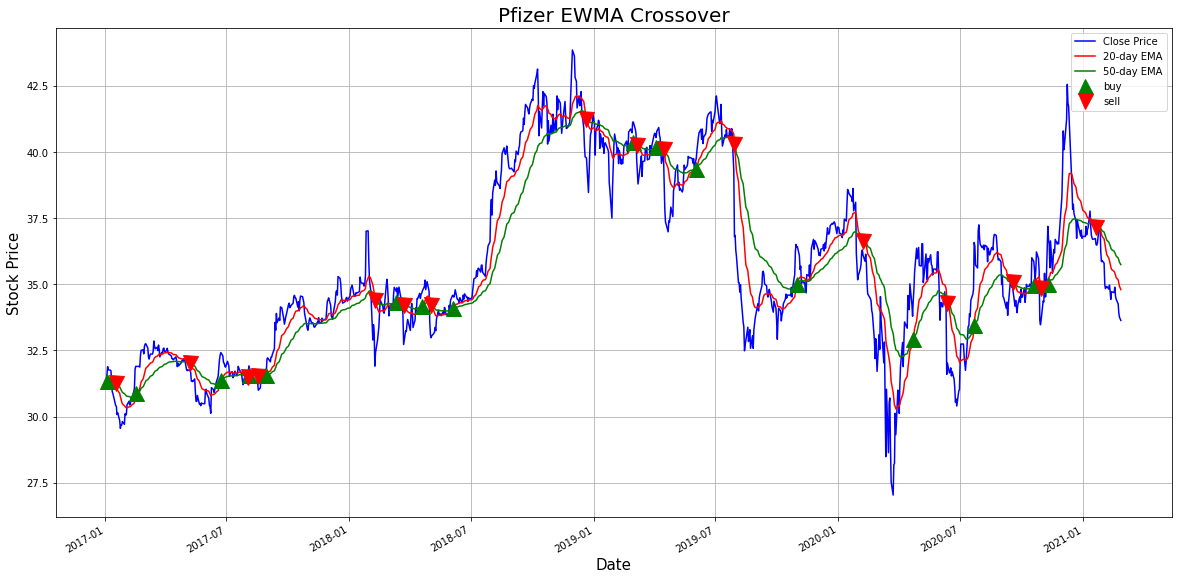

In [40]:
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
ewmal_1['Close'].plot(color = 'b', label= 'Close Price') 
ewmal_1['20_EMA'].plot(color = 'r',label = '20-day EMA') 
ewmal_1['50_EMA'].plot(color = 'g', label = '50-day EMA')
# plot ‘buy’ signals
plt.plot(ewmal_1[ewmal_1['Position'] == 1].index, 
         ewmal_1['20_EMA'][ewmal_1['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(ewmal_1[ewmal_1['Position'] == -1].index, 
         ewmal_1['20_EMA'][ewmal_1['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer EWMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Rate of Change
The Rate of Change (ROC) is a technical indicator that measures the percentage change between the most recent price and the price "n" day’s ago. The indicator fluctuates around the zero line.
#### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? This is a complex question with multiple possible answer.  One possible answer is that as the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.  https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp<br>
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp The column 'change' shows how volatile the price change percentage wise. The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.



### Price Change in Dollars
To see how big the changes in price were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  A column named 'Actual_Changes' is added to calculate actual change in dollars.<br>For example, we can see that on 1/3/17 the Adj Closing price was 26.653324 and on 1/4/17 the Adj Closing price was 26.887548 so the price change $0.234224.<br> 
Expected change (1 std deviaiton movement in price)<br>
Column of calculation of how big the actual changes was interms of standard deviations.<br>
Histograms changes in standard deviation<br>
Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [41]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [42]:
#leavr off 1 b/c that's default value
#using shift function
#price decreased by -$1.148

price_change['Actual_Changes'] = price_change['Adj Close'] - price_change['Adj Close'].shift(1)
# price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 
price_change

,Close,Volume,Adj Close,Actual_Changes
Date,,,,
2017-01-03,31.309298,23391844.0,26.653324,NaN
2017-01-04,31.584440,22753963.0,26.887548,0.234224
2017-01-05,31.888046,21083584.0,27.146002,0.258453
2017-01-06,31.764706,18418228.0,27.041008,-0.104994
2017-01-09,31.755219,21559886.0,27.032928,-0.008080
...,...,...,...,...
2021-02-19,34.439999,28089400.0,34.439999,-0.120003
2021-02-22,34.259998,34247500.0,34.259998,-0.180000
2021-02-23,33.910000,37603300.0,33.910000,-0.349998


The below graph shows that for the stated time the stock price never changed more than $2.627 than 3.00 nor a price difference negatively of more than -2.511.<br>

In [43]:
#the mean (average) change was less than 1 cent
price_change['Actual_Changes'].describe() 

count    1043.000000
mean        0.006694
std         0.477503
min        -2.511635
25%        -0.178858
50%         0.008389
75%         0.214265
max         2.627960
Name: Actual_Changes, dtype: float64

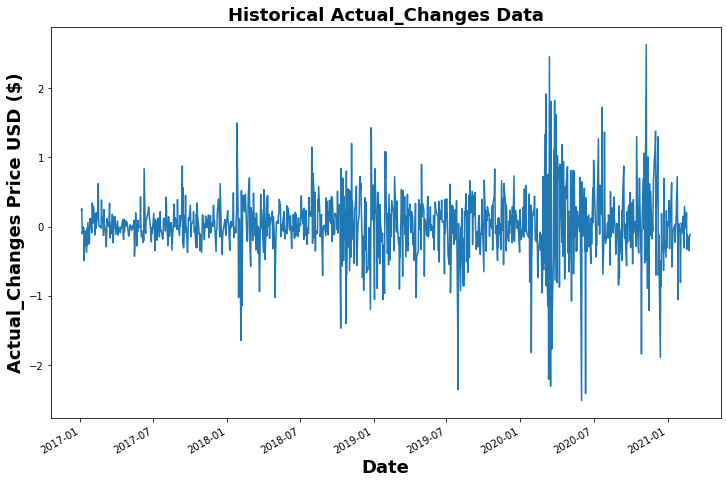

In [44]:
single_plot(price_change, stock_value='Actual_Changes')

In [45]:
multi_stocks

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN
...,...,...,...,...,...,...
2021-03-01,33.689999,159.320007,240.289993,157.399994,48.090000,110.209999
2021-03-02,33.509998,159.020004,205.990005,146.809998,47.730000,104.980003
2021-03-03,34.389999,156.220001,183.610001,131.220001,47.160000,97.250000


In [46]:
multi_price_change = multi_stocks.copy()

In [47]:
multi_price_change = multi_price_change - multi_price_change.shift(1)

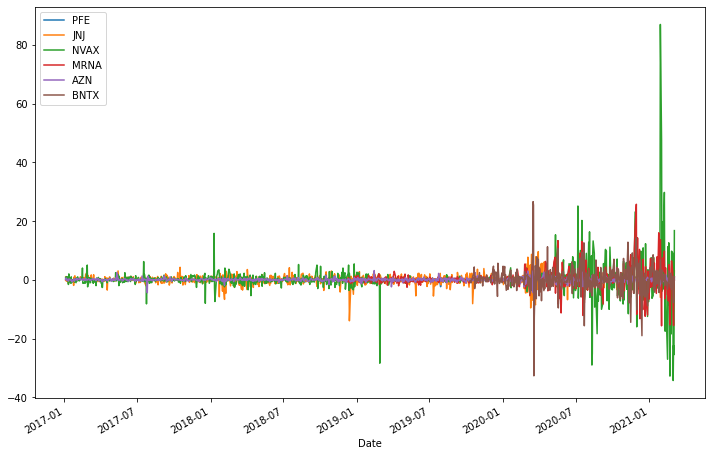

In [48]:
#plt.figure()
multi_price_change.plot(figsize=(12,8))

In [49]:
multi_price_change.describe()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
count,1049.000000,1049.000000,1049.000000,563.000000,1049.000000,352.000000
mean,0.007375,0.050203,0.142459,0.201758,0.023476,0.232841
std,0.477144,1.732085,5.218199,3.569540,0.679066,4.665182
min,-2.511635,-13.964050,-34.299988,-15.680008,-4.421049,-32.700001
25%,-0.180000,-0.586121,-0.600000,-0.695001,-0.245258,-1.842497
50%,0.008556,0.079514,0.000000,0.020000,0.028324,0.105000
75%,0.214186,0.794785,0.629999,0.975000,0.304443,2.329998
max,2.627960,9.590652,86.930008,25.710007,3.912495,26.599998


### Simple Daily Return
Daily price change as a percentage

In [50]:
multi_stocks.head()

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,26.653324,103.436539,25.400000,NaN,23.433638,NaN
2017-01-04,26.887548,103.266876,26.200001,NaN,23.619688,NaN
2017-01-05,27.146002,104.347321,26.400000,NaN,24.262403,NaN
2017-01-06,27.041008,103.847282,27.400000,NaN,24.042524,NaN
2017-01-09,27.032928,103.829422,28.400000,NaN,24.127094,NaN


In [51]:
(26.200001 /25.400000) -1

0.0314961023622049

In [52]:
#clculate simple daily return for each day for each stock
#new price(cuurent time period) /old price - 1
#26.887548 - 26.653324=
daily_simple_returns = multi_stocks.pct_change(1) #1 is for 1 day
daily_simple_returns

,PFE,JNJ,NVAX,MRNA,AZN,BNTX
Date,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,0.008788,-0.001640,0.031496,NaN,0.007939,NaN
2017-01-05,0.009612,0.010463,0.007634,NaN,0.027211,NaN
2017-01-06,-0.003868,-0.004792,0.037879,NaN,-0.009063,NaN
2017-01-09,-0.000299,-0.000172,0.036496,NaN,0.003518,NaN
...,...,...,...,...,...,...
2021-03-01,0.005972,0.005427,0.039182,0.016730,-0.005994,0.010823
2021-03-02,-0.005343,-0.001883,-0.142744,-0.067281,-0.007486,-0.047455
2021-03-03,0.026261,-0.017608,-0.108646,-0.106192,-0.011942,-0.073633


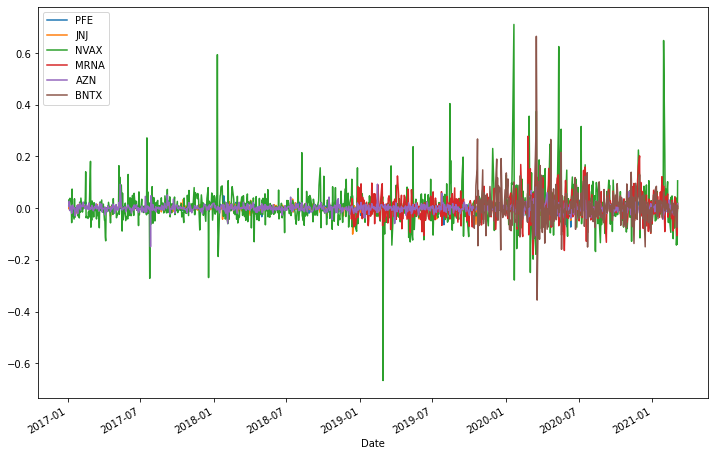

In [53]:
daily_simple_returns.plot(figsize=(12,8))

In [54]:
36.551258 - 37.603287

-1.0520290000000045

#### Volatility

In [55]:
#0.008750

#550–500) / 500)*100

# 26.653324
# 26.887548
# 26.888 - 26.653 = 0.234224
single_sdr = pfe_stock_data.copy()


daily_simple_returns_1 = single_sdr['Adj Close'].pct_change(1) #1 is for 1 day
daily_simple_returns_1

Date
2017-01-03         NaN
2017-01-04    0.008788
2017-01-05    0.009612
2017-01-06   -0.003868
2017-01-09   -0.000299
                ...   
2021-02-19   -0.003472
2021-02-22   -0.005226
2021-02-23   -0.010216
2021-02-24   -0.004718
2021-02-26   -0.003407
Name: Adj Close, Length: 1044, dtype: float64

For most days the daily returns in the price of stock are between 0.025 and -0.025.  There are a few spikes exceeeding 0.050 and -0.050. 

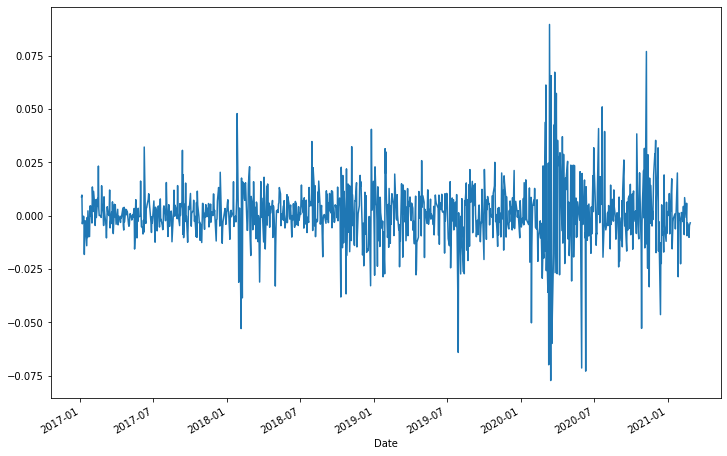

In [56]:
plt.figure(figsize=(12,8))
daily_simple_returns_1.plot()

Text(0, 0.5, 'Frequency')

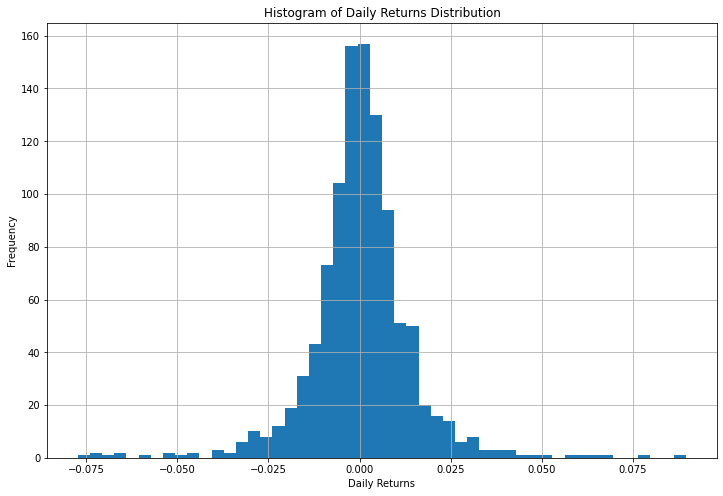

In [57]:
plt.figure(figsize=(12,8))
daily_simple_returns_1.hist(bins=50)
plt.title('Histogram of Daily Returns Distribution')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')

the mean daily returns has been about 0.072 and the daily return was less than 1% for stated time period meaninging that the Pfizer stock has been less volatile over the period.  The highest percentage change in the postive direction was 0.089 and in the negative direction was -0.077. 

In [58]:
daily_simple_returns_1.describe()

count    1043.000000
mean        0.000328
std         0.014465
min        -0.077347
25%        -0.005462
50%         0.000266
75%         0.006463
max         0.089607
Name: Adj Close, dtype: float64

In [59]:
#stock volatility
#print standard deviaiton for daily simple return
#volatility is standard deviation
#Most volatile stock is NVAX, least volatile stock is JNJ
#the higher the volaitility the higher hte return, the lower volatility the lower return
#expect a lower return for JNJ as opposed to BNTX
print('The Stock Volatility')
daily_simple_returns.std()

The Stock Volatility


PFE     0.014453
JNJ     0.013317
NVAX    0.077243
MRNA    0.052314
AZN     0.016451
BNTX    0.078415
dtype: float64

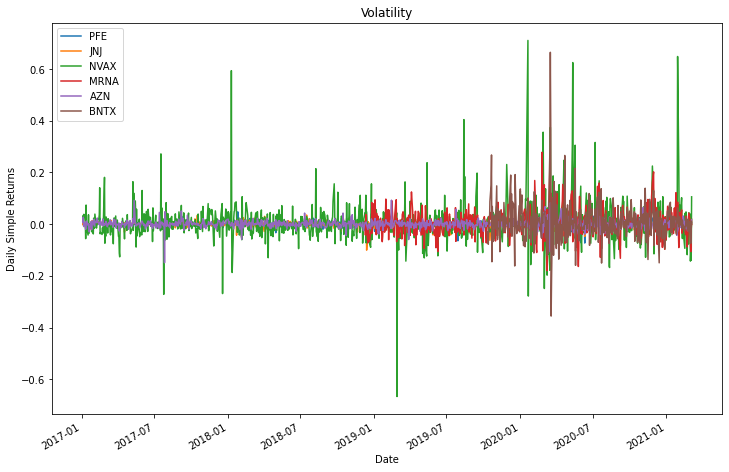

In [60]:
#vislauize stocks simple daily returns/Volaitilty
#NVAX and BNTX are very volatile
#AZN is right in the middle and not that voaltile
daily_simple_returns.plot(figsize=(12,8));
plt.title('Volatility')
plt.ylabel('Daily Simple Returns')
plt.legend()

In [61]:
#mean of daily simple return
#highest return should be NBTX and lowest for PFE
mean_dsr = daily_simple_returns.mean()
print('The Daily Mean Simple Return')
mean_dsr

The Daily Mean Simple Return


PFE     0.000347
JNJ     0.000481
NVAX    0.004729
MRNA    0.004821
AZN     0.000821
BNTX    0.008299
dtype: float64

In [62]:
#calculate historical volatility
prct_change = price_change.copy()
prct_change['change'] = np.log(prct_change['Close'] / prct_change['Close'].shift()) #divide by previous days close

In [63]:
#prct_change

In [64]:
#graph centered around 0
#price only went up 7% twice and around 3/20 went down below 7% a few times
#8/19 went below &%
# plt.figure(figsize=(12,6))
# plt.plot(prct_change['change'])

### Historical Volatility

In [65]:
#use  rolling standard deviation to get that 
#use 21 day rolling window b/c there are 21 traing days in a month on average
#this will include 21st observation
#but volatility should be used from next day
prct_change['Volatility'] = prct_change['change'].rolling(21).std().shift(1)

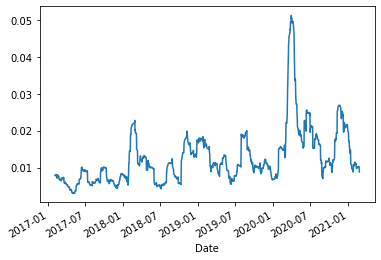

In [66]:
#what price volatility looks like over time
#4/20 was a highly volatile period
prct_change['Volatility'].plot()

In [67]:
#use rolling standard deviation to ge that. Use 21 day rolling window.
#use today's volatility at close today to predcit a 1 std move tomorrow
prct_change['Expected_Change'] = prct_change['Close'].shift(1) * prct_change['Volatility'] #1 std or 21 day rolling std
prct_change = prct_change.iloc[1:]
prct_change

,Close,Volume,Adj Close,Actual_Changes,change,Volatility,Expected_Change
Date,,,,,,,
2017-01-04,31.584440,22753963.0,26.887548,0.234224,0.008750,NaN,NaN
2017-01-05,31.888046,21083584.0,27.146002,0.258453,0.009567,NaN,NaN
2017-01-06,31.764706,18418228.0,27.041008,-0.104994,-0.003875,NaN,NaN
2017-01-09,31.755219,21559886.0,27.032928,-0.008080,-0.000299,NaN,NaN
2017-01-10,31.726755,20444754.0,27.008699,-0.024229,-0.000897,NaN,NaN
...,...,...,...,...,...,...,...
2021-02-19,34.439999,28089400.0,34.439999,-0.120003,-0.003478,0.010285,0.355435
2021-02-22,34.259998,34247500.0,34.259998,-0.180000,-0.005240,0.010257,0.353239
2021-02-23,33.910000,37603300.0,33.910000,-0.349998,-0.010268,0.010257,0.351405


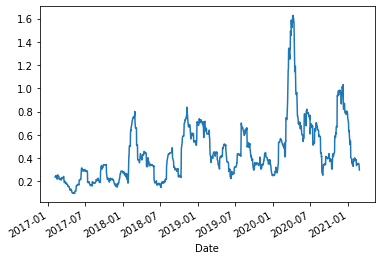

In [68]:
prct_change['Expected_Change'].plot()

In [69]:
#magnitude of change
#divide actual change by expected change
#end up w/values in standard deviations
prct_change['Magnitude'] = prct_change['Actual_Changes'] / prct_change['Expected_Change']

(array([  1.,   0.,   2.,   1.,   1.,   0.,   1.,   5.,   2.,   1.,   2.,
          3.,   8.,   5.,   4.,   8.,  28.,  20.,  43.,  45.,  74.,  96.,
        113., 109., 107.,  80.,  80.,  61.,  46.,  21.,  13.,  10.,   9.,
          6.,   3.,   3.,   1.,   1.,   2.,   1.,   0.,   2.,   1.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([-5.08297846, -4.86449985, -4.64602124, -4.42754263, -4.20906402,
        -3.99058541, -3.77210679, -3.55362818, -3.33514957, -3.11667096,
        -2.89819235, -2.67971374, -2.46123512, -2.24275651, -2.0242779 ,
        -1.80579929, -1.58732068, -1.36884207, -1.15036345, -0.93188484,
        -0.71340623, -0.49492762, -0.27644901, -0.0579704 ,  0.16050822,
         0.37898683,  0.59746544,  0.81594405,  1.03442266,  1.25290127,
         1.47137989,  1.6898585 ,  1.90833711,  2.12681572,  2.34529433,
         2.56377295,  2.78225156,  3.00073017,  3.21920878,  3.43768739,
         3.6

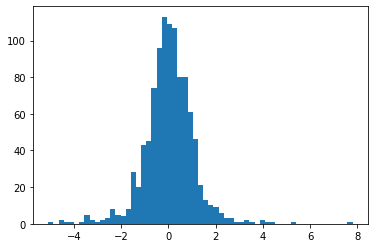

In [70]:
#idea of typical distrubution of changes in terms of standard deviation
#mostly w/in 3 stadnard deviaitons of mean
#could be more of positve change
#kind of equal happening on positve and negative side
plt.hist(prct_change['Magnitude'], bins='auto')

### RSI

In [71]:
rsi_df = pfe_stock_data.copy()
rsi_df.head()

,Close,Volume,Adj Close
Date,,,
2017-01-03,31.309298,23391844.0,26.653324
2017-01-04,31.584440,22753963.0,26.887548
2017-01-05,31.888046,21083584.0,27.146002
2017-01-06,31.764706,18418228.0,27.041008
2017-01-09,31.755219,21559886.0,27.032928


In [72]:
#get the difference in price from previous day
delta = rsi_df['Adj Close'].diff(1) #26.887548 - 26.653324
delta

Date
2017-01-03         NaN
2017-01-04    0.234224
2017-01-05    0.258453
2017-01-06   -0.104994
2017-01-09   -0.008080
                ...   
2021-02-19   -0.120003
2021-02-22   -0.180000
2021-02-23   -0.349998
2021-02-24   -0.160000
2021-02-26   -0.115002
Name: Adj Close, Length: 1044, dtype: float64

In [73]:
#get rid of NaN
delta = delta.dropna()
delta

Date
2017-01-04    0.234224
2017-01-05    0.258453
2017-01-06   -0.104994
2017-01-09   -0.008080
2017-01-10   -0.024229
                ...   
2021-02-19   -0.120003
2021-02-22   -0.180000
2021-02-23   -0.349998
2021-02-24   -0.160000
2021-02-26   -0.115002
Name: Adj Close, Length: 1043, dtype: float64

In [74]:
#get teh postive gains (up) and negative gains(down)
up = delta.copy()
down = delta.copy()

#get the postive values in delta
up[up < 0]=0  #for any values in up that are less than 0. Any values n up that are less than 0, we'll set to 0
down[down > 0]=0  #values in down that are greater than 0, they're postive. Set those values equal to 0.
#up only contins positve values and down only contains negative values

In [75]:
#Get the time period.  RSI is usually 14 day period
period=14
#calculate the average gain and average loss
AVG_gain = up.rolling(window=period).mean()
AVG_loss = abs(down.rolling(window=period).mean()) #going to be negative values so use absolute

In [76]:

#calcualte RSI

#calcualte relative strength (Rs)
RS = AVG_gain / AVG_loss
#calcualte relative strength Index (RSI)
RSI = 100.0 - (100.0 / (1.0 + RS))

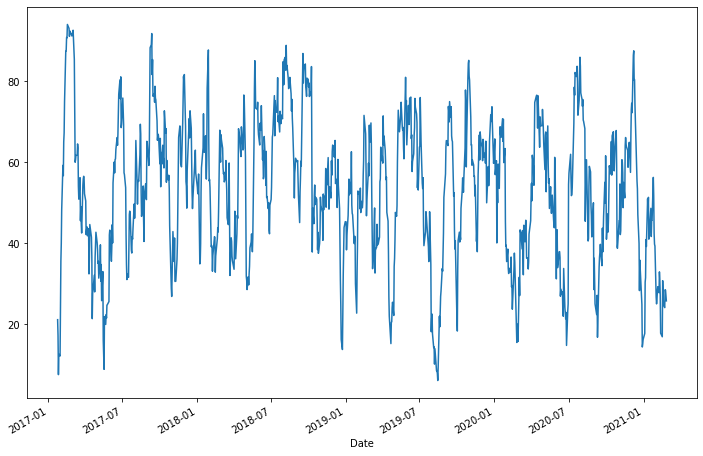

In [77]:
plt.figure(figsize=(12,8))
RSI.plot()

In [78]:
#new dataframe
new_df = pd.DataFrame()
new_df['Adj Close'] = rsi_df['Adj Close']
new_df['RSI'] = RSI

In [79]:
new_df

,Adj Close,RSI
Date,,
2017-01-03,26.653324,NaN
2017-01-04,26.887548,NaN
2017-01-05,27.146002,NaN
2017-01-06,27.041008,NaN
2017-01-09,27.032928,NaN
...,...,...
2021-02-19,34.439999,24.827583
2021-02-22,34.259998,24.161088
2021-02-23,33.910000,28.571429


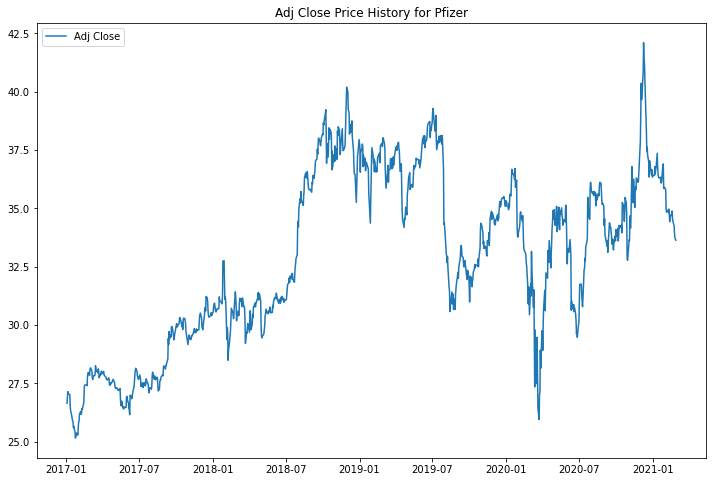

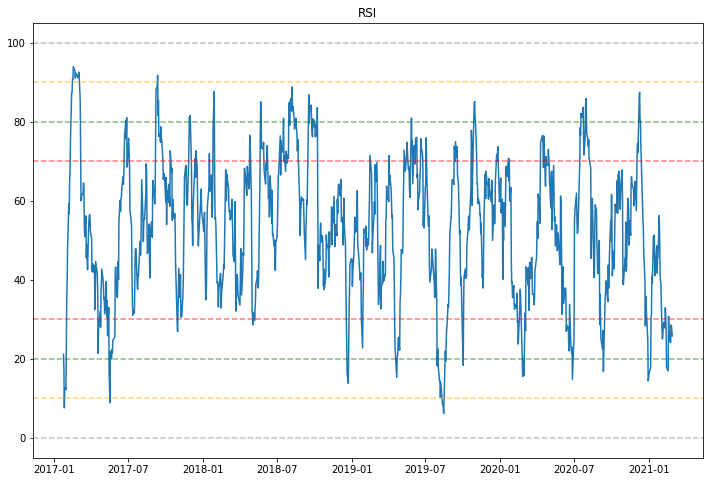

In [80]:
"""
7/19-RSI value dips below 10 indicator, the 10 significant level.
    Tells us stock was oversold and presents a buying opportunity
On Adj Close plot was see that around 7/19 the price dipped from around $40.00 to $30.00.
    Then the price increased significantly again.
If yo ufollowed RSI you wuold have prucahsed around $30.00 and prcie jumped to $37.5 around 1/20.    

Around 7/18 to 9/18- Looks like stock was being over bought.  RSI value passed 80 level significant indicator.
    price was around $38.00 to 40.00.
    Pricde did drop to almost $35.00. Would have been a good time to drop prior to the drop.
    Would have saved some money from selling

"""
#plot adjuted close
plt.figure(figsize=(12,8))
plt.plot(new_df.index, new_df['Adj Close'])
plt.title('Adj Close Price History for Pfizer')
plt.legend(new_df.columns.values, loc='upper left')
#plot RSI values and signficant levels
plt.figure(figsize=(12,8))
plt.title('RSI')
plt.plot(new_df.index,new_df['RSI'])
plt.axhline(0, linestyle='--', alpha=0.5,color='gray')
plt.axhline(10, linestyle='--', alpha=0.5,color='orange')
plt.axhline(20, linestyle='--', alpha=0.5,color='green')
plt.axhline(30, linestyle='--', alpha=0.5,color='red')
plt.axhline(70, linestyle='--', alpha=0.5,color='red')
plt.axhline(80, linestyle='--', alpha=0.5,color='green')
plt.axhline(90, linestyle='--', alpha=0.5,color='orange')
plt.axhline(100, linestyle='--', alpha=0.5,color='gray')

## Question 2: How well can historical data and algorithms predict future stocks prices? 
This section focuses on using Long Short Term Memory (LSTM) and SARIMA models to predict future stock prices.

In [ ]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [ ]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [ ]:
sarima_data = pfe_stock_data.copy()

In [ ]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')

In [ ]:
sarima_df

##### Train/Test Split

In [ ]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
n = int(len(sarima_df) * 0.8)
train = sarima_df[:n]
test = sarima_df[n:]

##### ARIMA Model

In [ ]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


###### ARIMA / Adj Close

In [ ]:
sarima_col = 'Adj Close'

In [ ]:
stepwise_fit = arima_model(train[sarima_col])

In [ ]:
stepwise_fit.summary()

In [ ]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
#train['Adj Close'][[0,-1]]
train[sarima_col][[0,-1]]

In [ ]:
#test['Adj Close'][[0,-1]]
test[sarima_col][[0,-1]]

In [ ]:
hist_type = sarima_col #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
plt.figure(figsize=(12,6))
# Plot observed values

#ax = train['Adj Close']['2019':].plot(label='observed')
ax = train[sarima_col]['2019':].plot(label='observed')#
#test['Adj Close']['2019':].plot()#label='Test'
test[sarima_col]['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

In [ ]:
# Get the real and predicted values
forecast = pred.predicted_mean
actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
history_type = sarima_col #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[history_type])
prediction_visual

In [ ]:
# Get the real and predicted values
forecast = pred_dynamic.predicted_mean
actual = train[history_type]#['1996':]

# Compute the mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
##### SARIMA / MA_50

In [ ]:
sarima_col_1 = 'MA_50'

In [ ]:
#stepwise_fit = arima_model(train['Adj Close'])
stepwise_fit = arima_model(train[sarima_col])

In [ ]:
stepwise_fit.summary()

In [ ]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

In [ ]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [ ]:
#train['Adj Close'][[0,-1]]
train[sarima_col_1][[0,-1]]

In [ ]:
#test['Adj Close'][[0,-1]]
test[sarima_col_1][[0,-1]]

In [ ]:
hist_type = sarima_col_1 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
plt.figure(figsize=(12,6))
# Plot observed values

#ax = train['Adj Close']['2019':].plot(label='observed')
ax = train[sarima_col_1]['2019':].plot(label='observed')#
#test['Adj Close']['2019':].plot()#label='Test'
test[sarima_col_1]['2019':].plot()#label='Test'
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()

In [ ]:
# Get the real and predicted values
forecast = pred.predicted_mean
actual =test[sarima_col_1]['1996':] #actual =test['Adj Close']['1996':]

# Compute the root mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
history_type = sarima_col_1 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-01-10'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [ ]:
def prediction_vis(pred_dynamic,pred_dynamic_conf, y):
  # Plot the dynamic forecast with confidence intervals.
  plt.figure(figsize=(12,5))
  # Plot observed values
  ax = y.plot(label='Observed')

  # Plot predicted values
  pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

  # Plot the range for confidence intervals
  ax.fill_between(pred_dynamic_conf.index,
                  pred_dynamic_conf.iloc[:, 0],
                  pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

  # Set axes labels
  ax.set_xlabel('Date')
  ax.set_ylabel('Sale Price')
  plt.legend()

  return ax

In [ ]:
prediction_visual = prediction_vis(pred_dynamic,pred_dynamic_conf,train[history_type])
prediction_visual

In [ ]:
# # Get the real and predicted values
# forecast_11238 = pred_dynamic.predicted_mean
# truth_11238 = train[current_zip]#['1996':]

# # Compute the mean square error
# mse = ((forecast_11238 - truth_11238) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast_11238 - truth_11238) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [ ]:
# Get the real and predicted values
forecast = pred_dynamic.predicted_mean
actual = train[history_type]#['1996':]

# Compute the mean square error
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecast - actual) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

### LTSM / Multi-Stocks


In [ ]:
multi_stocks

In [ ]:
def delta_time_series(data,col=None):
#     data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
#     data['Percent_Chg'] = data[col].pct_change(1)
#     data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
multi = delta_time_series(multi_stocks, col='Adj Close')
multi

In [ ]:
multi.shape

In [ ]:
def plot_delta(data,col=None,symbol=None):
    #plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    data.plot(figsize=(12,6))
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

In [ ]:
#simple daily return
#centered aroun d 0
plot_delta(multi)

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='PFE', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

#### Train Test Split

In [ ]:
train_size = int(len(multi) * 0.80)#0.67
test_size = len(multi) - train_size

In [ ]:
multi.index[train_size]

In [ ]:
multi.index[-test_size]


In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot(figsize=(12,8))
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(multi)

#### Normalize Data

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
col_index['PFE']

#### Timeseries Generator

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='PFE')

In [ ]:
# ex_X, ex_y = train_data_gen[0]
# ex_X.shape

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [ ]:
# model_params = save_model(model)

In [ ]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

#### RMSE Function

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#a value of 0 means predcitions were exact
#models got values exactly as they were supposed to from testing data
#what in normalized
model_metrics(y_train,y_hat_train)

#### Prediction Plot

In [ ]:
#red what th model actually predicted
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM / Single Stock

In [ ]:
#df_single.to_csv('single_stock')

# single = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
# single

In [ ]:
# pfe_stock_data
pfe_stock_data

In [ ]:
def delta_time_series1(data,col=None):
    data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [ ]:
single = delta_time_series1(pfe_stock_data, col='Adj Close')
single

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
train_size = int(len(single) * 0.80)#0.67
test_size = len(single) - train_size

In [ ]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

In [ ]:
train, val, test= train_test_val(single)

In [ ]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [ ]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [ ]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

In [ ]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

In [ ]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Adj Close')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = True))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

model1.add(Dense(units = 25,activation='relu'))
model1.add(Dense(units = 1))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model1.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model1.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
trainPredict = model1.predict_generator(train_data_gen)
trainPredict.shape

In [ ]:
testPredict = model1.predict_generator(test_data_gen)
testPredict.shape

In [ ]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

In [ ]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

In [ ]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [ ]:
#what in normalized
model_metrics(y_train,y_hat_train)

In [ ]:
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM and Technical Indicators

#### Percent_Chg

In [ ]:
#train_scaled_df.columns

#single

In [ ]:
col_index['MA_50']

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='MA_50')

In [ ]:
sample = ex_X[0]
sample.shape

In [ ]:
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = False))
model2.add(Dropout(0.2))

model2.add(Dense(units = 25))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

model2.summary()    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model2.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

In [ ]:
model2.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='MA_50'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
#look_back=3

In [ ]:
trainPredict = model2.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model2.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
model_metrics(y_test,y_hat_test)

In [ ]:
# plt.figure(figsize=(12,6))
# y_train.plot(label='train')
# y_test.plot(label='test')
# y_val.plot(label='val')
# y_hat_test.plot(label='Prediction')
# #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
# plt.legend()
prediction_plot(y_train,y_test,y_val,y_hat_test)

### Actual_change

In [ ]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Actual_Changes')

In [ ]:
model3 = Sequential()

model3.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = False))
model3.add(Dropout(0.2))

model3.add(Dense(units = 25, activation='relu'))
model3.add(Dense(units = 1))

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

model3.summary()    

In [ ]:
hist = model3.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,
                           callbacks=[early_stop])

In [ ]:
model3.evaluate_generator(test_data_gen)

In [ ]:
pd.DataFrame(hist.history).plot()

In [ ]:
def get_y_from_df(train_scaled_df, look_back, col='Actual_Changes'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [ ]:
plt.plot(trainPredict)

In [ ]:
trainPredict = model3.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model3.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [ ]:
model_metrics(y_train,y_hat_train)

In [ ]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

In [ ]:
print('Testing 2-26-21')